# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [4]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 102 (delta 56), reused 33 (delta 33), pack-reused 22 (from 1)
Receiving objects: 100% (102/102), 6.36 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (56/56), done.


# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [5]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2.70G/2.70G [00:12<00:00, 209MB/s]


In [9]:
print("type(vae):", type(vae))
print("vae:", type(vae))
output_dir = "./vae_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存模型结构和权重
vae.save_pretrained(output_dir)
print("模型已保存到", output_dir)

type(vae): <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>
vae: <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>
模型已保存到 ./vae_model


In [16]:
import json
from safetensors.torch import load_file
model_path2 = "./vae_model"
config_path2 = os.path.join(model_path2, "config.json")

with open(config_path2, 'r', encoding='utf-8') as f:
    config_dict2 = json.load(f)

# 创建模型实例并加载权重
vae2 = AutoencoderKL.from_config(config_dict2)
weights_path2 = os.path.join(model_path2, "diffusion_pytorch_model.safetensors")
# state_dict2 = load_file(weights_path2, device="cuda:0")  # 假设您想要加载到 GPU 上
state_dict2 = load_file(weights_path2)
vae2.load_state_dict(state_dict2)
print("type(vae2):", type(vae2))


type(vae2): <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>


In [19]:
import torch

# 假设 vae1 和 vae2 是您想要比较的两个 VAE 模型实例
# 首先获取两个模型的状态字典
state_dict1 = vae.state_dict()
state_dict2 = vae2.state_dict()

# 确认两个状态字典拥有相同的键
if state_dict1.keys() == state_dict2.keys():
    # 对于每个键，检查对应的张量是否足够接近
    all_close = True
    for key in state_dict1.keys():
        tmp1 = state_dict1[key].to(device)
        tmp2 = state_dict2[key].to(device)
        if not torch.allclose(tmp1, tmp2):
            print(f"参数 {key} 不匹配")
            all_close = False
            break
    if all_close:
        print("两个模型的参数完全一致")
else:
    print("两个模型的结构不同")

两个模型的参数完全一致


# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

  0%|          | 0/250 [00:00<?, ?it/s]

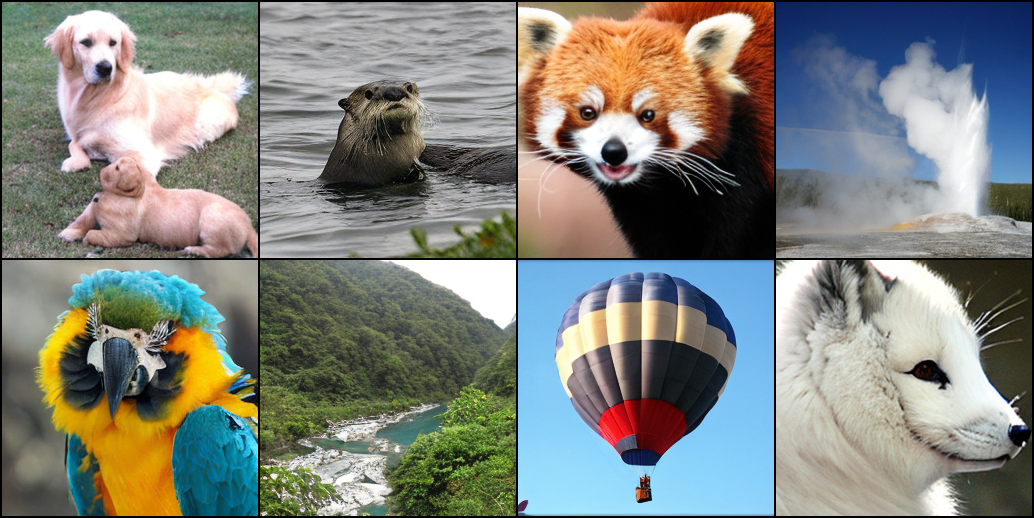

In [6]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)